<a href="https://colab.research.google.com/github/pachterlab/CWGFLHGCCHAP_2021/blob/master/notebooks/CellAtlasAnalysis/gastroGeneModuleAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Download Data**

In [1]:
import requests
from tqdm import tnrange, tqdm_notebook
def download_file(doi,ext):
    url = 'https://api.datacite.org/dois/'+doi+'/media'
    r = requests.get(url).json()
    netcdf_url = r['data'][0]['attributes']['url']
    r = requests.get(netcdf_url,stream=True)
    #Set file name
    fname = doi.split('/')[-1]+ext
    #Download file with progress bar
    if r.status_code == 403:
        print("File Unavailable")
    if 'content-length' not in r.headers:
        print("Did not get file")
    else:
        with open(fname, 'wb') as f:
            total_length = int(r.headers.get('content-length'))
            pbar = tnrange(int(total_length/1024), unit="B")
            for chunk in r.iter_content(chunk_size=1024):
                if chunk:
                    pbar.update()
                    f.write(chunk)
        return fname

In [2]:
#Kallisto bus clustered starvation data, h5ad
download_file('10.22002/D1.1796','.gz')

#Starvation h5ad data, all nonzero genes included, filtered for 'real cells' from de-multiplexing
download_file('10.22002/D1.1797','.gz')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


'D1.1797.gz'

In [3]:
#Human ortholog annotations
download_file('10.22002/D1.1819','.gz')

#Panther annotations
download_file('10.22002/D1.1820','.gz')

#GO Terms
download_file('10.22002/D1.1822','.gz')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


'D1.1822.gz'

In [4]:
!gunzip *.gz

In [5]:
#Install packages
!pip install --quiet anndata
!pip install --quiet scanpy==1.6.0

!pip install --quiet louvain
# !pip install --quiet anndata2ri

     |████████████████████████████████| 133kB 28.9MB/s 
     |████████████████████████████████| 7.7MB 19.1MB/s 
     |████████████████████████████████| 81kB 8.9MB/s 
     |████████████████████████████████| 1.2MB 43.6MB/s 
     |████████████████████████████████| 71kB 8.8MB/s 
     |████████████████████████████████| 2.2MB 26.2MB/s 
     |████████████████████████████████| 3.2MB 44.9MB/s 


In [6]:
!pip3 install --quiet rpy2

In [15]:
!pip install --quiet cellbrowser

     |████████████████████████████████| 40.0MB 109kB/s 


###**Import Packages** 

In [8]:
#Import Packages

import random
import pandas as pd
import anndata
import scanpy as sc
import numpy as np
import scipy.sparse

import scipy.io as sio
import warnings
warnings.filterwarnings('ignore')

from sklearn.neighbors import (KNeighborsClassifier,NeighborhoodComponentsAnalysis)
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE

#import scrublet as scr

import matplotlib.pyplot as plt
%matplotlib inline
sc.set_figure_params(dpi=125)

import seaborn as sns
sns.set(style="whitegrid")
%load_ext rpy2.ipython

In [9]:
#Read in annotations
from io import StringIO

hg_ortho_df = pd.read_csv(StringIO(''.join(l.replace('|', '\t') for l in open('D1.1819'))),
            sep="\t",header=None,skiprows=[0,1,2,3])

hg_ortho_df[['XLOC','TCONS']] = hg_ortho_df[13].str.split(expand=True) 
hg_ortho_df[['Gene','gi']] = hg_ortho_df[3].str.split(expand=True) 
hg_ortho_df['Description']= hg_ortho_df[11]


panther_df = pd.read_csv('D1.1820',
            sep="\t",header=None) #skiprows=[0,1,2,3]



goTerm_df = pd.read_csv('D1.1822',
            sep=" ",header=None) #skiprows=[0,1,2,3]

In [10]:
bus_fs_combo = anndata.read('D1.1796')
print(bus_fs_combo)


AnnData object with n_obs × n_vars = 13673 × 8696
    obs: 'batch', 'n_counts', 'n_countslog', 'louvain', 'leiden', 'orgID', 'fed', 'starved', 'fed_neighbor_score', 'cellRanger_louvain', 'annos', 'new_cellRanger_louvain', 'annosSub'
    var: 'n_counts', 'mean', 'std'
    uns: 'annosSub_colors', 'annos_colors', 'cellRanger_louvain_colors', 'cellRanger_louvain_sizes', "dendrogram_['new_cellRanger_louvain']", 'dendrogram_new_cellRanger_louvain', 'fed_colors', 'fed_neighbor_score_colors', 'leiden', 'leiden_colors', 'louvain', 'louvain_colors', 'neighbors', 'new_cellRanger_louvain_colors', 'orgID_colors', 'paga', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_nca', 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'


In [12]:
# bus_fs_raw  = anndata.read('D1.1797')
# bus_fs_raw.obs['cellRanger_louvain'] = pd.Categorical(bus_fs_combo.obs['cellRanger_louvain'])
# bus_fs_raw.obs['fed'] = pd.Categorical(bus_fs_combo.obs['fed'])
# bus_fs_raw.obs['orgID'] = pd.Categorical(bus_fs_combo.obs['orgID'])
# bus_fs_raw.obs['annos'] = pd.Categorical(bus_fs_combo.obs['annos'])
# bus_fs_raw.obs['annosSub'] = pd.Categorical(bus_fs_combo.obs['annosSub'])

# bus_fs_raw.uns['annos_colors'] = bus_fs_combo.uns['annos_colors']
# bus_fs_raw.uns['cellRanger_louvain_colors'] = bus_fs_combo.uns['annosSub_colors']

# bus_fs_raw.obsm['X_umap'] = bus_fs_combo.obsm['X_umap']
# #bus_fs_raw.uns['annosSub_colors'] = bus_fs_combo.uns['annosSub_colors']

# sc.pp.filter_genes(bus_fs_raw, min_counts=0)
# sc.pp.filter_cells(bus_fs_raw, min_counts=0)

# sc.pp.normalize_per_cell(bus_fs_raw, counts_per_cell_after=1e4)
# bus_fs_raw.raw = sc.pp.log1p(bus_fs_raw, copy=True)

# print(bus_fs_raw)

AnnData object with n_obs × n_vars = 13673 × 46716
    obs: 'batch', 'cellRanger_louvain', 'fed', 'orgID', 'annos', 'annosSub', 'n_counts'
    var: 'n_counts'
    uns: 'annos_colors', 'cellRanger_louvain_colors'
    obsm: 'X_umap'


In [13]:
# bus_fs_raw.write_h5ad('ucscClytia20210517.h5ad')

In [ ]:
# !cbImportScanpy -i ucscClytia20210517.h5ad -o ucscClytia20210517Scanpy --clusterField annosSub


In [ ]:
# %cd ucscClytia20210517Scanpy
# !cbBuild -o ./cb


In [ ]:
# !zip -r /content/cb.zip /content/ucscClytia20210517Scanpy/cb

In [19]:
# from google.colab import files
# files.download("/content/cb.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Read in saved data
bus_fs_combo = anndata.read('D1.1796')
print(bus_fs_combo)

bus_fs_raw  = anndata.read('D1.1797')
bus_fs_raw.obs['cellRanger_louvain'] = pd.Categorical(bus_fs_combo.obs['cellRanger_louvain'])
bus_fs_raw.obs['fed'] = pd.Categorical(bus_fs_combo.obs['fed'])
bus_fs_raw.obs['orgID'] = pd.Categorical(bus_fs_combo.obs['orgID'])
bus_fs_raw.obs['annos'] = pd.Categorical(bus_fs_combo.obs['annos'])
bus_fs_raw.obs['annosSub'] = pd.Categorical(bus_fs_combo.obs['annosSub'])

bus_fs_raw.uns['annos_colors'] = bus_fs_combo.uns['annos_colors']
bus_fs_raw.uns['cellRanger_louvain_colors'] = bus_fs_combo.uns['annosSub_colors']
#bus_fs_raw.uns['annosSub_colors'] = bus_fs_combo.uns['annosSub_colors']
print(bus_fs_raw)


AnnData object with n_obs × n_vars = 13673 × 8696
    obs: 'batch', 'n_counts', 'n_countslog', 'louvain', 'leiden', 'orgID', 'fed', 'starved', 'fed_neighbor_score', 'cellRanger_louvain', 'annos', 'new_cellRanger_louvain', 'annosSub'
    var: 'n_counts', 'mean', 'std'
    uns: 'annosSub_colors', 'annos_colors', 'cellRanger_louvain_colors', 'cellRanger_louvain_sizes', "dendrogram_['new_cellRanger_louvain']", 'dendrogram_new_cellRanger_louvain', 'fed_colors', 'fed_neighbor_score_colors', 'leiden', 'leiden_colors', 'louvain', 'louvain_colors', 'neighbors', 'new_cellRanger_louvain_colors', 'orgID_colors', 'paga', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_nca', 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'
AnnData object with n_obs × n_vars = 13673 × 46716
    obs: 'batch', 'cellRanger_louvain', 'fed', 'orgID', 'annos', 'annosSub'
    uns: 'annos_colors', 'cellRanger_louvain_colors'


In [ ]:
#Make dataframe, with 100 marker genes for each cluster + annotations
def annotateResDF(resultDF):
  orthoGene = []
  orthoDescr = []

  pantherNum = []
  pantherDescr = []

  goTerms = []

  genes = resultDF.Genes

  for g in genes:
          
    sub_df = hg_ortho_df[hg_ortho_df.XLOC.isin([g])]
    panth_df = panther_df[panther_df[0].isin([g])]
    go_df = goTerm_df[goTerm_df[0].isin([g])]

    if len(sub_df) > 0:
      #Save first result for gene/description
      orthoGene += [list(sub_df.Gene)[0]]
      orthoDescr += [list(sub_df.Description)[0]]
    else:
      orthoGene += ['NA']
      orthoDescr += ['NA']


    if len(panth_df) > 0:
      pantherNum += [list(panth_df[1])]
      pantherDescr += [list(panth_df[2])]
    else:
      pantherNum += ['NA']
      pantherDescr += ['NA']


    if len(go_df) > 0:
      goTerms += [list(go_df[1])]
    else:
      goTerms += ['NA']
  

  resultDF['orthoGene'] = orthoGene
  resultDF['orthoDescr'] = orthoDescr

  resultDF['pantherID'] = pantherNum
  resultDF['pantherDescr'] = pantherDescr

  resultDF['goTerms'] = goTerms
      
  return resultDF
  #list(neurons.uns['rank_genes_groups']['names']['1'])

### **Gastroderm Cell Type Gene Modules**

In [ ]:
#Gastroderm: 

gastro = bus_fs_raw[bus_fs_raw.obs['cellRanger_louvain'].isin([3,7,14,15,19,24])]
gastro_copy = gastro.copy()

#Normalize and scale data
sc.pp.filter_genes(gastro_copy, min_counts=0)
sc.pp.filter_cells(gastro_copy, min_counts=0)

sc.pp.normalize_per_cell(gastro_copy, counts_per_cell_after=1e4)
gastro_copy.raw = sc.pp.log1p(gastro_copy, copy=True)

sc.pp.scale(gastro_copy, max_value=10)

sc.pp.highly_variable_genes(gastro_copy,n_top_genes=10000)
gastro_copy = gastro_copy[:,gastro_copy.var['highly_variable']]
gastro_copy

#gastro = gastro[:,gastro_copy.var_names]

View of AnnData object with n_obs × n_vars = 2564 × 10000
    obs: 'batch', 'cellRanger_louvain', 'fed', 'orgID', 'annos', 'annosSub', 'n_counts'
    var: 'n_counts', 'mean', 'std', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'annos_colors', 'cellRanger_louvain_colors', 'hvg'

In [ ]:
gastro = gastro[:,bus_fs_combo.var_names]

In [ ]:
gastro

View of AnnData object with n_obs × n_vars = 2564 × 8696
    obs: 'batch', 'cellRanger_louvain', 'fed', 'orgID', 'annos', 'annosSub'
    uns: 'annos_colors', 'cellRanger_louvain_colors'

In [ ]:
#Transpose cellxgene
g_mod = anndata.AnnData(X=gastro.X.T)
g_mod.var_names = gastro.obs_names
g_mod.obs_names = gastro.var_names

print(g_mod)

g_copy = g_mod.copy()

AnnData object with n_obs × n_vars = 8696 × 2564


In [ ]:
#Scale and select top variable genes

#Normalize and scale data
sc.pp.filter_genes(g_copy, min_counts=0)

#sc.pp.normalize_per_cell(g_copy, counts_per_cell_after=1e4)
sc.pp.log1p(g_copy)

sc.pp.scale(g_copy, max_value=10)
sc.tl.pca(g_copy, n_comps=60,random_state=42)
#sc.pl.pca_variance_ratio(bus_combo, log=True)

#Determine neighbors for clustering
sc.pp.neighbors(g_copy,n_neighbors=15, n_pcs=15) #n_neighbors=5, n_pcs=15,  20, n_pcs=15
sc.tl.louvain(g_copy, resolution=4)



In [ ]:
# sc.tl.tsne(g_copy, n_pcs=15,random_state=42)
# sc.pl.tsne(g_copy,color=['louvain'])


In [ ]:
clusters = np.unique(g_copy.obs['louvain'])

In [ ]:
#Louvain clustering on genes across cells

genes = []
cluster = []
for c in clusters:
  sub = g_copy[g_copy.obs['louvain'] == c]
  genes += list(sub.obs_names)
  cluster += [c]*len(sub.obs_names)

genesDF = pd.DataFrame()
genesDF["Genes"] = genes
genesDF["Cluster"] = cluster

genesDF = annotateResDF(genesDF)
genesDF.head()

,Genes,Cluster,orthoGene,orthoDescr,pantherID,pantherDescr,goTerms
0,XLOC_000079,0,PDIA6,protein disulfide-isomerase A6 isoform a [Hom...,[PTHR45815:SF3],[PROTEIN DISULFIDE-ISOMERASE A6],"[GO:0044238,GO:0006457,GO:0016853,GO:0019538,G..."
1,XLOC_000112,0,NA,NA,[PTHR23050:SF414],[CALMODULIN],"[GO:0019722,GO:0009987,GO:0007165,GO:0006928,G..."
2,XLOC_000338,0,NA,NA,[PTHR35263],[TESTIS-EXPRESSED PROTEIN 49],[nan]
3,XLOC_000296,0,HSD17B12,estradiol 17-beta-dehydrogenase 12 [Homo sapi...,[PTHR43899:SF13],[RH59310P],"[GO:0044238,GO:0006629,GO:0003824,GO:0008152,G..."
4,XLOC_000404,0,BLOC1S6,biogenesis of lysosome-related organelles com...,[PTHR31328],[BIOGENESIS OF LYSOSOME-RELATED ORGANELLES COM...,"[GO:0005737,GO:0043234,GO:0006810,GO:0032991,G..."


In [ ]:
genesDF.to_csv('gastroModules.csv',index=None)

In [ ]:
#Plot heatmap of average expression for each gene module in each cell type
modExpr = pd.DataFrame()
module = []
c_type = []
expr = []

cell_types = np.unique(gastro.obs['cellRanger_louvain'])
for i in clusters:
  #Get list of genes
  sub = g_copy[g_copy.obs['louvain'] == i]
  genes = list(sub.obs_names)

  for j in cell_types:
  #Filter cells and genes
    sub_g = gastro[gastro.obs['cellRanger_louvain'] == j]
    sub_g = sub_g[:,genes]
    expr += [np.log1p(np.sum(sub_g.X))]

    c_type += [j]
    module += [i]

modExpr['module'] = module
modExpr['type'] = c_type
modExpr['expr'] = expr


modExpr.head()
modExpr = modExpr.pivot("module", "type", "expr")

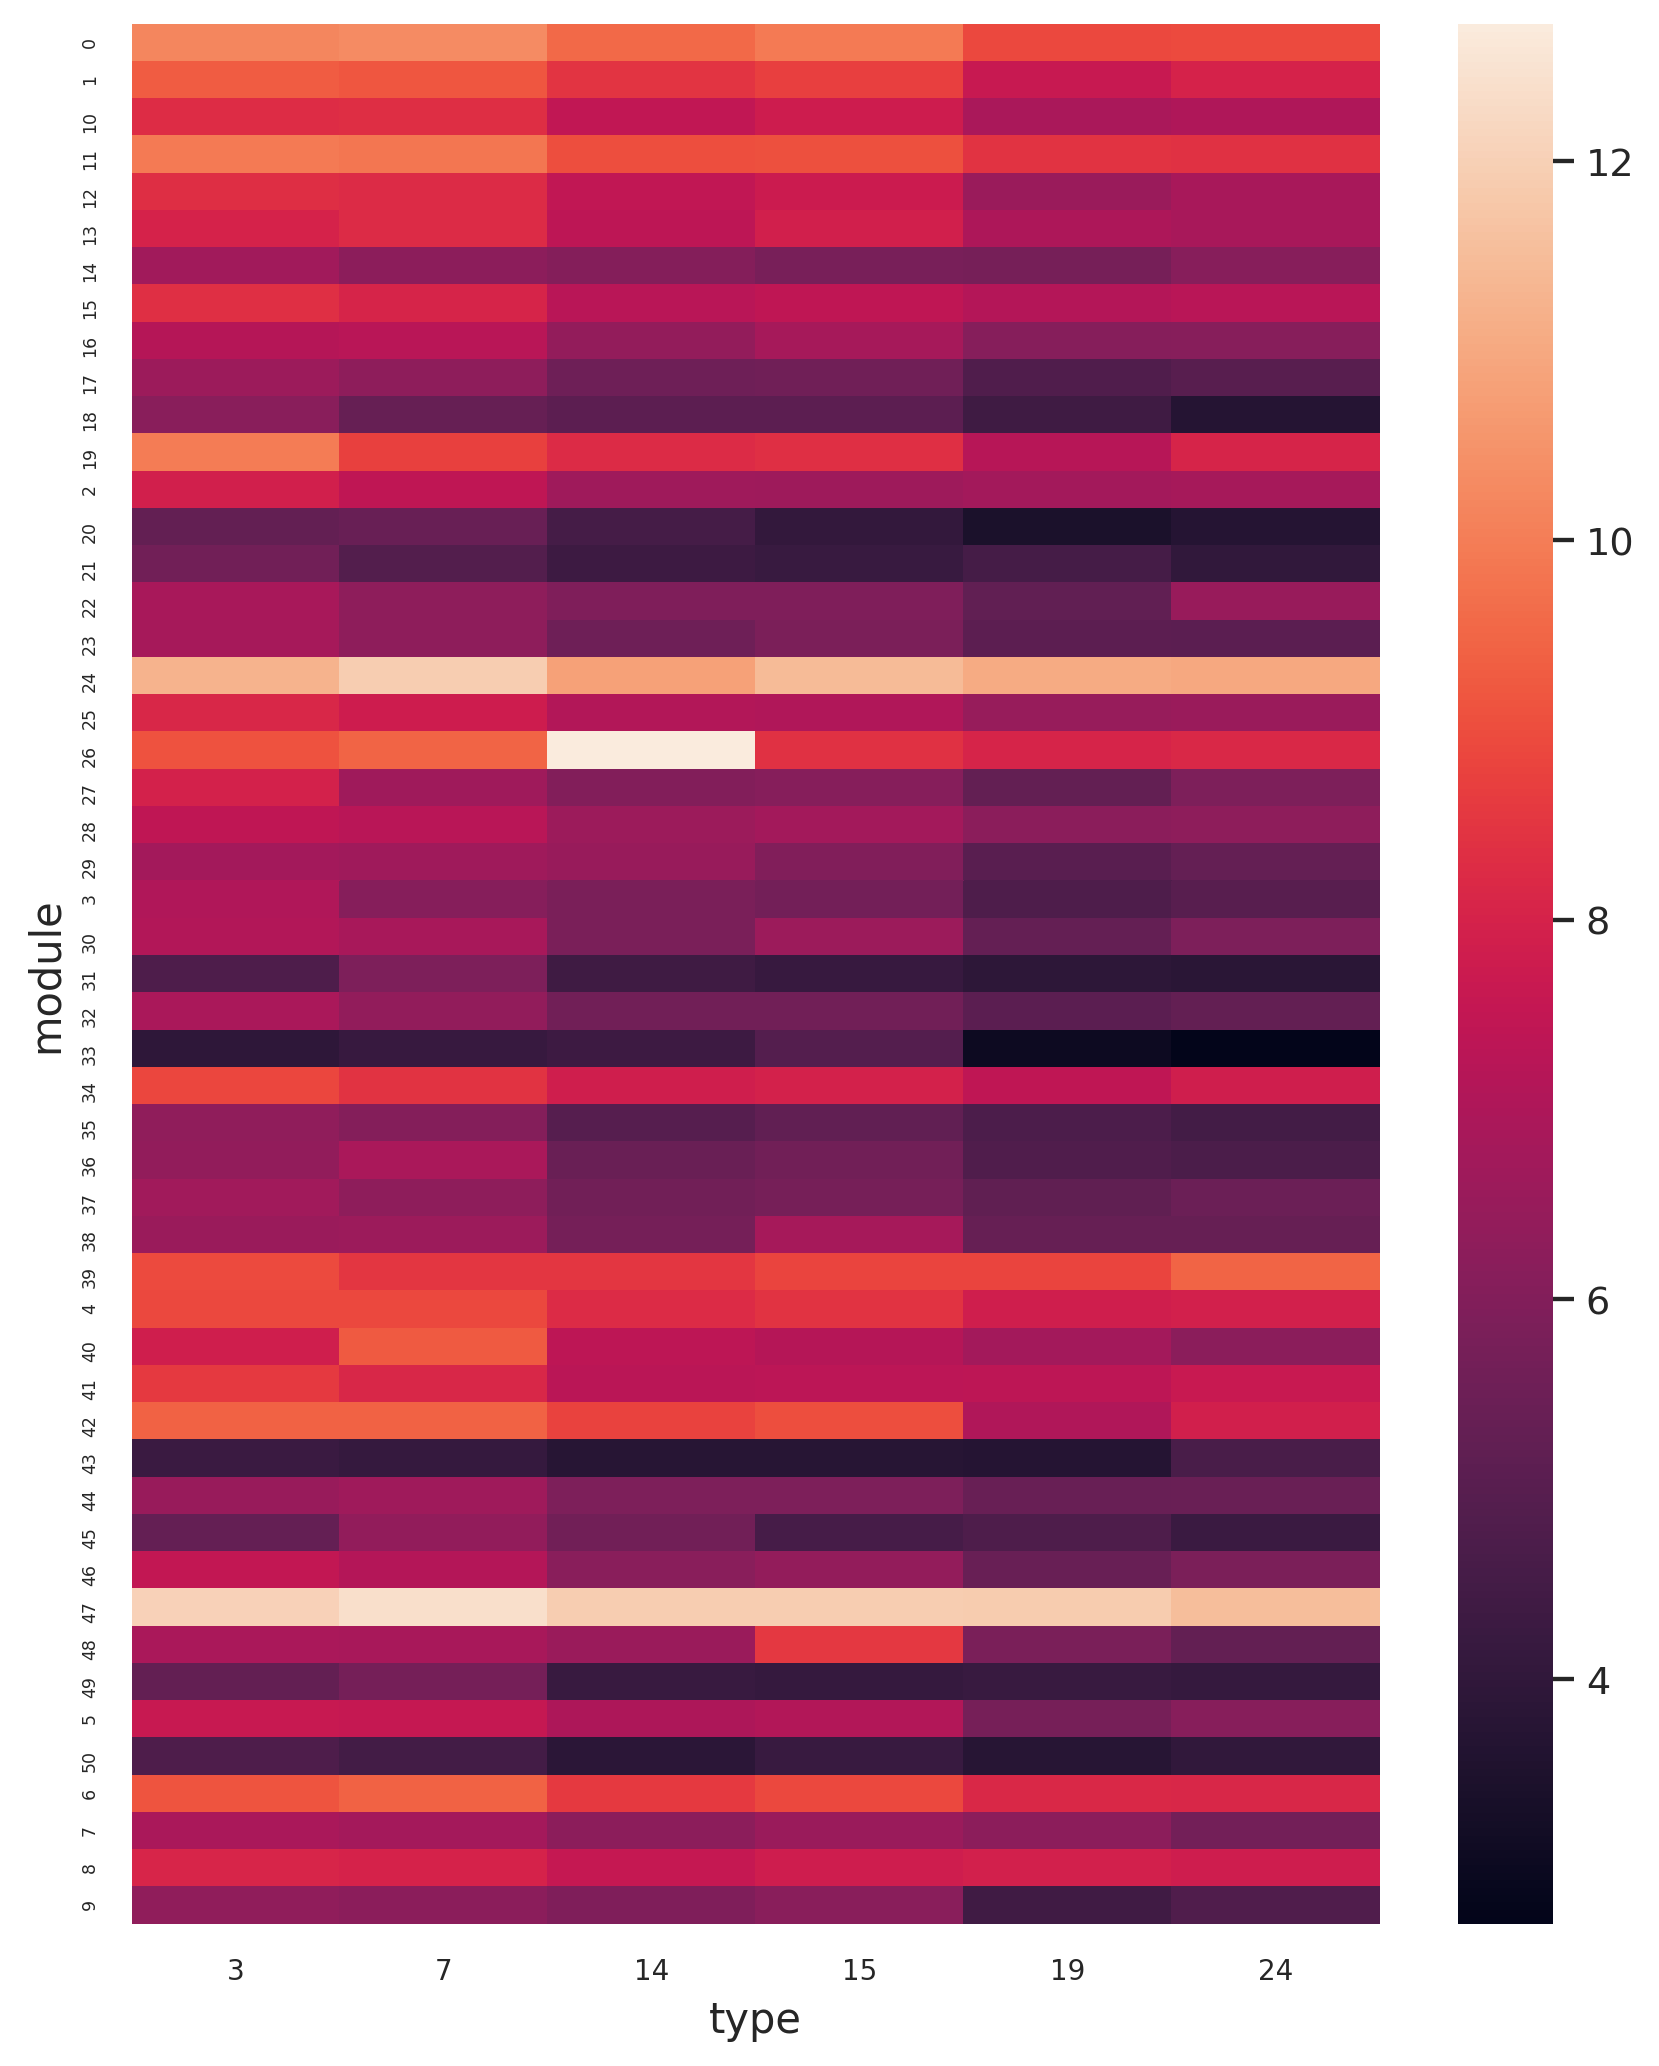

In [ ]:
#Original hvgs, res = 4
plt.figure(figsize=(8,10))
plt.yticks(fontsize=5)
plt.xticks(fontsize=8)
ax = sns.heatmap(modExpr)

Check for GO Term Enrichment in Modules

In [ ]:
#For topGO analysis (To Assign Labels to Modules)

def returnVal(i):
  if i == i:
    i= i.replace("[","")
    i = i.replace("]","")
    i= i.replace("'","")
    i = i.replace("'","")
    return i 
  else:
    return 'nan'

genesDF.goTerms = [returnVal(str(i)) for i in list(genesDF.goTerms)]
genesDF = genesDF[genesDF.goTerms != 'nan']
genesDF = genesDF[genesDF.Cluster != 'padjClus_not_sig']

genesDF.to_csv('genes_fortopGO_metadata.txt',sep='\t',columns=['Genes','goTerms','Cluster'],
             header=None,index_label=False,index=False)
genesDF.to_csv('genes_fortopGO.txt',sep='\t',columns=['Genes','goTerms'],
             header=None,index_label=False,index=False)

In [ ]:
%%R 

install.packages('rlang')
if (!requireNamespace("BiocManager", quietly=TRUE)){
  install.packages("BiocManager")
}

BiocManager::install("topGO")


R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/rlang_0.4.10.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 915685 bytes (894 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write

Update all/some/none? [a/s/n]: a


R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/dbplyr_2.1.1.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 581845 bytes (568 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]

In [ ]:
%%R

library(topGO)
library(readr)
#Read in DE genes (XLOC's) with GO Terms
geneID2GO <- readMappings(file = "genes_fortopGO.txt")
str(head(geneID2GO ))

#Add gene modules as factor 
genes_fortopGO_metadata <- read_delim("genes_fortopGO_metadata.txt", 
                                                   "\t", escape_double = FALSE, col_names = FALSE, 
                                                   trim_ws = TRUE)

#Set variables
allMods = unique(genes_fortopGO_metadata$X3)
alpha = 0.05/length(allMods) #Bonferroni correction, could correct for all pairwise comparisons?


getEnrichTerms <- function(geneID2GO, modMetadata, clus){
  mods <- factor(as.integer(modMetadata$X3 == clus)) #Choose gene module to make 'interesting'
  names(mods) <- names(geneID2GO)

  
  #Get genes only in module of interest
  clusGenes <- function(mods) {
    return(mods == 1)
  }
  subMods <- clusGenes(mods)
  
  #Make GO data
  GOdata <- new("topGOdata", ontology = "BP", allGenes = mods,
                geneSel = subMods, annot = annFUN.gene2GO, gene2GO = geneID2GO)
  
  #GOdata
  #sigGenes(GOdata)
  
  resultFis <- runTest(GOdata, algorithm = "classic", statistic = "fisher")
  
  resultWeight <- runTest(GOdata, statistic = "fisher")

  #P-values from Weight Algorithm
  pvalsWeight <- score(resultWeight)
  
  #hist(pvalsWeight, 50, xlab = "p-values")
  
  allRes <- GenTable(GOdata, classic = resultFis, weight = resultWeight, 
                     orderBy = "weight", ranksOf = "classic", topNodes = 20)
  
  subRes <- allRes[as.numeric(allRes$weight) < alpha,]

  subRes$module <- rep(clus, length(subRes$weight))

  print(subRes)
  
  #Write output
  write.csv(subRes,file=paste('mod',clus,'_GOTerms.csv',sep=""))
}

#Run for all modules and write outputs
for(c in allMods){
  
  getEnrichTerms(geneID2GO = geneID2GO,modMetadata = genes_fortopGO_metadata, clus = c)
  
}

List of 6
 $ XLOC_000079: chr [1:10] "GO:0044238" "GO:0006457" "GO:0016853" "GO:0019538" ...
 $ XLOC_000112: chr [1:11] "GO:0019722" "GO:0009987" "GO:0007165" "GO:0006928" ...
 $ XLOC_000296: chr [1:6] "GO:0044238" "GO:0006629" "GO:0003824" "GO:0008152" ...
 $ XLOC_000404: chr [1:12] "GO:0005737" "GO:0043234" "GO:0006810" "GO:0032991" ...
 $ XLOC_000487: chr [1:4] "GO:0016787" "GO:0006796" "GO:0008152" "GO:0003824"
 $ XLOC_000618: chr [1:4] "GO:0005634" "GO:0044464" "GO:0043226" "GO:0005622"

── Column specification ────────────────────────────────────────────────────────
cols(
  X1 = col_character(),
  X2 = col_character(),
  X3 = col_double()
)



R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 391 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 391 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 13:	1 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 12:	7 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	11 nodes to be scored	(6 eliminated genes)

R[write to console]: 
	 Level 10:	13 nodes to be scored	(395 eliminated genes)

R[write to console]: 
	 Level 9:	30 nodes to be scored	(46

       GO.ID                                 Term Annotated Significant
1 GO:0022904 respiratory electron transport chain        34           8
  Expected Rank in classic classic weight module
1     1.88               2 0.00040 0.0004      0


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 292 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 292 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	5 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	7 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	8 nodes to be scored	(385 eliminated genes)

R[write to console]: 
	 Level 9:	15 nodes to be scored	(452 eliminated genes)

R[write to console]: 
	 Level 8:	31 nodes to be scored	(60

       GO.ID                         Term Annotated Significant Expected
1 GO:0006351 transcription, DNA-templated       368          32    15.69
  Rank in classic classic  weight module
1              22 4.6e-05 0.00021      1


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 284 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 284 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	4 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	6 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	7 nodes to be scored	(382 eliminated genes)

R[write to console]: 
	 Level 9:	13 nodes to be scored	(440 eliminated genes)

R[write to console]: 
	 Level 8:	25 nodes to be scored	(59

       GO.ID                                        Term Annotated Significant
1 GO:0006796 phosphate-containing compound metabolic ...       596          36
  Expected Rank in classic classic  weight module
1     20.4               2 0.00024 1.9e-05     10


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 284 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 284 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	2 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	3 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	6 nodes to be scored	(312 eliminated genes)

R[write to console]: 
	 Level 9:	12 nodes to be scored	(370 eliminated genes)

R[write to console]: 
	 Level 8:	20 nodes to be scored	(57

       GO.ID                          Term Annotated Significant Expected
1 GO:0051180             vitamin transport        54          10     1.07
2 GO:0009605 response to external stimulus       118          13     2.33
3 GO:0007398          ectoderm development        88          10     1.74
4 GO:0006508                   proteolysis       244          16     4.81
5 GO:0007601             visual perception        62           8     1.22
6 GO:0006897                   endocytosis       170          13     3.35
7 GO:0007498          mesoderm development        99           9     1.95
  Rank in classic classic  weight module
1               1 5.5e-08 5.5e-08     11
2               2 2.9e-07 1.3e-06     11
3               3 6.1e-06 6.1e-06     11
4               4 1.3e-05 1.3e-05     11
5               6 2.2e-05 2.2e-05     11
6               5 1.9e-05 2.3e-05     11
7               9 0.00011 0.00011     11


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 343 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 343 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	4 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	8 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	8 nodes to be scored	(374 eliminated genes)

R[write to console]: 
	 Level 9:	16 nodes to be scored	(452 eliminated genes)

R[write to console]: 
	 Level 8:	33 nodes to be scored	(60

[1] GO.ID           Term            Annotated       Significant    
[5] Expected        Rank in classic classic         weight         
[9] module         
<0 rows> (or 0-length row.names)


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 336 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 336 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	3 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	6 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	9 nodes to be scored	(370 eliminated genes)

R[write to console]: 
	 Level 9:	17 nodes to be scored	(444 eliminated genes)

R[write to console]: 
	 Level 8:	28 nodes to be scored	(60

[1] GO.ID           Term            Annotated       Significant    
[5] Expected        Rank in classic classic         weight         
[9] module         
<0 rows> (or 0-length row.names)


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 296 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 296 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	2 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	4 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	6 nodes to be scored	(322 eliminated genes)

R[write to console]: 
	 Level 9:	12 nodes to be scored	(395 eliminated genes)

R[write to console]: 
	 Level 8:	28 nodes to be scored	(54

[1] GO.ID           Term            Annotated       Significant    
[5] Expected        Rank in classic classic         weight         
[9] module         
<0 rows> (or 0-length row.names)


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 266 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 266 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	4 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	5 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	6 nodes to be scored	(371 eliminated genes)

R[write to console]: 
	 Level 9:	14 nodes to be scored	(428 eliminated genes)

R[write to console]: 
	 Level 8:	23 nodes to be scored	(55

[1] GO.ID           Term            Annotated       Significant    
[5] Expected        Rank in classic classic         weight         
[9] module         
<0 rows> (or 0-length row.names)


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 330 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 330 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 13:	1 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 12:	4 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	6 nodes to be scored	(6 eliminated genes)

R[write to console]: 
	 Level 10:	10 nodes to be scored	(376 eliminated genes)

R[write to console]: 
	 Level 9:	17 nodes to be scored	(446

       GO.ID                                Term Annotated Significant Expected
1 GO:0007249 I-kappaB kinase/NF-kappaB signaling        69           9     2.06
2 GO:0007254                         JNK cascade        58           8     1.73
  Rank in classic classic  weight module
1               1 0.00017 0.00017     16
2               2 0.00027 0.00027     16


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 234 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 234 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	3 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	4 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	4 nodes to be scored	(370 eliminated genes)

R[write to console]: 
	 Level 9:	9 nodes to be scored	(428 eliminated genes)

R[write to console]: 
	 Level 8:	18 nodes to be scored	(529

       GO.ID                                 Term Annotated Significant
1 GO:0007502 digestive tract mesoderm development         2           2
2 GO:0009790                   embryo development        24           4
3 GO:0007379                segment specification        11           3
  Expected Rank in classic classic  weight module
1     0.03               1 0.00027 0.00027     17
2     0.40               4 0.00056 0.00056     17
3     0.18               5 0.00064 0.00064     17


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 253 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 253 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	2 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	3 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	6 nodes to be scored	(312 eliminated genes)

R[write to console]: 
	 Level 9:	10 nodes to be scored	(370 eliminated genes)

R[write to console]: 
	 Level 8:	20 nodes to be scored	(49

[1] GO.ID           Term            Annotated       Significant    
[5] Expected        Rank in classic classic         weight         
[9] module         
<0 rows> (or 0-length row.names)


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 263 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 263 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	2 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	4 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	4 nodes to be scored	(322 eliminated genes)

R[write to console]: 
	 Level 9:	6 nodes to be scored	(395 eliminated genes)

R[write to console]: 
	 Level 8:	18 nodes to be scored	(497

[1] GO.ID           Term            Annotated       Significant    
[5] Expected        Rank in classic classic         weight         
[9] module         
<0 rows> (or 0-length row.names)


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 310 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 310 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 13:	1 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 12:	4 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	5 nodes to be scored	(6 eliminated genes)

R[write to console]: 
	 Level 10:	8 nodes to be scored	(376 eliminated genes)

R[write to console]: 
	 Level 9:	19 nodes to be scored	(434 

[1] GO.ID           Term            Annotated       Significant    
[5] Expected        Rank in classic classic         weight         
[9] module         
<0 rows> (or 0-length row.names)


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 245 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 245 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	2 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	3 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	5 nodes to be scored	(312 eliminated genes)

R[write to console]: 
	 Level 9:	8 nodes to be scored	(370 eliminated genes)

R[write to console]: 
	 Level 8:	18 nodes to be scored	(451

       GO.ID                             Term Annotated Significant Expected
1 GO:0006812                 cation transport       162          14     2.63
2 GO:0050789 regulation of biological process      1187          30    19.28
  Rank in classic classic  weight module
1               1 1.5e-07 1.5e-07     20
2               3  0.0023 4.3e-06     20


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 221 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 221 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	3 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	4 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	4 nodes to be scored	(370 eliminated genes)

R[write to console]: 
	 Level 9:	8 nodes to be scored	(428 eliminated genes)

R[write to console]: 
	 Level 8:	16 nodes to be scored	(529

[1] GO.ID           Term            Annotated       Significant    
[5] Expected        Rank in classic classic         weight         
[9] module         
<0 rows> (or 0-length row.names)


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 263 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 263 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	3 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	4 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	5 nodes to be scored	(334 eliminated genes)

R[write to console]: 
	 Level 9:	8 nodes to be scored	(383 eliminated genes)

R[write to console]: 
	 Level 8:	22 nodes to be scored	(553

[1] GO.ID           Term            Annotated       Significant    
[5] Expected        Rank in classic classic         weight         
[9] module         
<0 rows> (or 0-length row.names)


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 249 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 249 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	2 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	3 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	7 nodes to be scored	(322 eliminated genes)

R[write to console]: 
	 Level 9:	11 nodes to be scored	(383 eliminated genes)

R[write to console]: 
	 Level 8:	22 nodes to be scored	(56

[1] GO.ID           Term            Annotated       Significant    
[5] Expected        Rank in classic classic         weight         
[9] module         
<0 rows> (or 0-length row.names)


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 223 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 223 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	2 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	3 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	5 nodes to be scored	(312 eliminated genes)

R[write to console]: 
	 Level 9:	7 nodes to be scored	(370 eliminated genes)

R[write to console]: 
	 Level 8:	17 nodes to be scored	(482

[1] GO.ID           Term            Annotated       Significant    
[5] Expected        Rank in classic classic         weight         
[9] module         
<0 rows> (or 0-length row.names)


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 183 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 183 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	1 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	2 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	3 nodes to be scored	(264 eliminated genes)

R[write to console]: 
	 Level 9:	6 nodes to be scored	(325 eliminated genes)

R[write to console]: 
	 Level 8:	12 nodes to be scored	(380

       GO.ID                 Term Annotated Significant Expected
1 GO:0007160 cell-matrix adhesion        51           5     0.68
  Rank in classic classic weight module
1               1  0.0005 0.0005     25


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 241 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 241 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	2 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	3 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	3 nodes to be scored	(322 eliminated genes)

R[write to console]: 
	 Level 9:	6 nodes to be scored	(383 eliminated genes)

R[write to console]: 
	 Level 8:	15 nodes to be scored	(484

       GO.ID                   Term Annotated Significant Expected
1 GO:0006811          ion transport       214           9     4.22
2 GO:0008643 carbohydrate transport        12           4     0.24
  Rank in classic classic  weight module
1               4  0.0232 1.9e-06     26
2               1 6.1e-05 6.1e-05     26


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 254 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 254 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	3 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	4 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	5 nodes to be scored	(370 eliminated genes)

R[write to console]: 
	 Level 9:	10 nodes to be scored	(428 eliminated genes)

R[write to console]: 
	 Level 8:	18 nodes to be scored	(54

[1] GO.ID           Term            Annotated       Significant    
[5] Expected        Rank in classic classic         weight         
[9] module         
<0 rows> (or 0-length row.names)


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 295 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 295 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	5 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	7 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	9 nodes to be scored	(383 eliminated genes)

R[write to console]: 
	 Level 9:	17 nodes to be scored	(440 eliminated genes)

R[write to console]: 
	 Level 8:	28 nodes to be scored	(60

[1] GO.ID           Term            Annotated       Significant    
[5] Expected        Rank in classic classic         weight         
[9] module         
<0 rows> (or 0-length row.names)


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 266 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 266 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	4 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	5 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	5 nodes to be scored	(373 eliminated genes)

R[write to console]: 
	 Level 9:	11 nodes to be scored	(440 eliminated genes)

R[write to console]: 
	 Level 8:	21 nodes to be scored	(54

[1] GO.ID           Term            Annotated       Significant    
[5] Expected        Rank in classic classic         weight         
[9] module         
<0 rows> (or 0-length row.names)


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 306 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 306 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	5 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	6 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	5 nodes to be scored	(386 eliminated genes)

R[write to console]: 
	 Level 9:	11 nodes to be scored	(428 eliminated genes)

R[write to console]: 
	 Level 8:	27 nodes to be scored	(56

       GO.ID                                Term Annotated Significant Expected
1 GO:0007274 neuromuscular synaptic transmission         2           2     0.06
  Rank in classic classic  weight module
1               7 0.00095 0.00095      3


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 213 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 213 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	2 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	4 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	5 nodes to be scored	(312 eliminated genes)

R[write to console]: 
	 Level 9:	7 nodes to be scored	(382 eliminated genes)

R[write to console]: 
	 Level 8:	13 nodes to be scored	(463

[1] GO.ID           Term            Annotated       Significant    
[5] Expected        Rank in classic classic         weight         
[9] module         
<0 rows> (or 0-length row.names)


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 249 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 249 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	1 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	2 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	4 nodes to be scored	(264 eliminated genes)

R[write to console]: 
	 Level 9:	8 nodes to be scored	(325 eliminated genes)

R[write to console]: 
	 Level 8:	19 nodes to be scored	(516

[1] GO.ID           Term            Annotated       Significant    
[5] Expected        Rank in classic classic         weight         
[9] module         
<0 rows> (or 0-length row.names)


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 278 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 278 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	3 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	4 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	5 nodes to be scored	(370 eliminated genes)

R[write to console]: 
	 Level 9:	11 nodes to be scored	(428 eliminated genes)

R[write to console]: 
	 Level 8:	24 nodes to be scored	(56

       GO.ID                   Term Annotated Significant Expected
1 GO:0007059 chromosome segregation        60           6     1.15
  Rank in classic classic  weight module
1               1 0.00087 0.00087     32


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 180 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 180 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	2 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	3 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	4 nodes to be scored	(322 eliminated genes)

R[write to console]: 
	 Level 9:	8 nodes to be scored	(383 eliminated genes)

R[write to console]: 
	 Level 8:	10 nodes to be scored	(516

       GO.ID                   Term Annotated Significant Expected
1 GO:0050877 nervous system process       184           7     2.03
  Rank in classic classic  weight module
1               2  0.0034 0.00097     33


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 212 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 212 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	1 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	3 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	6 nodes to be scored	(264 eliminated genes)

R[write to console]: 
	 Level 9:	12 nodes to be scored	(329 eliminated genes)

R[write to console]: 
	 Level 8:	16 nodes to be scored	(56

[1] GO.ID           Term            Annotated       Significant    
[5] Expected        Rank in classic classic         weight         
[9] module         
<0 rows> (or 0-length row.names)


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 222 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 222 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	1 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	2 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	5 nodes to be scored	(264 eliminated genes)

R[write to console]: 
	 Level 9:	8 nodes to be scored	(325 eliminated genes)

R[write to console]: 
	 Level 8:	14 nodes to be scored	(533

[1] GO.ID           Term            Annotated       Significant    
[5] Expected        Rank in classic classic         weight         
[9] module         
<0 rows> (or 0-length row.names)


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 257 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 257 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	2 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	3 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	8 nodes to be scored	(312 eliminated genes)

R[write to console]: 
	 Level 9:	14 nodes to be scored	(370 eliminated genes)

R[write to console]: 
	 Level 8:	22 nodes to be scored	(61

[1] GO.ID           Term            Annotated       Significant    
[5] Expected        Rank in classic classic         weight         
[9] module         
<0 rows> (or 0-length row.names)


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 218 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 218 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	1 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	2 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	4 nodes to be scored	(264 eliminated genes)

R[write to console]: 
	 Level 9:	7 nodes to be scored	(325 eliminated genes)

R[write to console]: 
	 Level 8:	16 nodes to be scored	(412

[1] GO.ID           Term            Annotated       Significant    
[5] Expected        Rank in classic classic         weight         
[9] module         
<0 rows> (or 0-length row.names)


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 217 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 217 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	3 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	4 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	4 nodes to be scored	(334 eliminated genes)

R[write to console]: 
	 Level 9:	7 nodes to be scored	(383 eliminated genes)

R[write to console]: 
	 Level 8:	15 nodes to be scored	(521

[1] GO.ID           Term            Annotated       Significant    
[5] Expected        Rank in classic classic         weight         
[9] module         
<0 rows> (or 0-length row.names)


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 206 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 206 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	2 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	4 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	4 nodes to be scored	(312 eliminated genes)

R[write to console]: 
	 Level 9:	11 nodes to be scored	(374 eliminated genes)

R[write to console]: 
	 Level 8:	16 nodes to be scored	(42

[1] GO.ID           Term            Annotated       Significant    
[5] Expected        Rank in classic classic         weight         
[9] module         
<0 rows> (or 0-length row.names)


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 304 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 304 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	4 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	6 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	8 nodes to be scored	(374 eliminated genes)

R[write to console]: 
	 Level 9:	14 nodes to be scored	(440 eliminated genes)

R[write to console]: 
	 Level 8:	24 nodes to be scored	(62

[1] GO.ID           Term            Annotated       Significant    
[5] Expected        Rank in classic classic         weight         
[9] module         
<0 rows> (or 0-length row.names)


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 190 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 190 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	2 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	3 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	4 nodes to be scored	(276 eliminated genes)

R[write to console]: 
	 Level 9:	5 nodes to be scored	(325 eliminated genes)

R[write to console]: 
	 Level 8:	13 nodes to be scored	(516

[1] GO.ID           Term            Annotated       Significant    
[5] Expected        Rank in classic classic         weight         
[9] module         
<0 rows> (or 0-length row.names)


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 147 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 147 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	2 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	4 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	3 nodes to be scored	(265 eliminated genes)

R[write to console]: 
	 Level 9:	5 nodes to be scored	(337 eliminated genes)

R[write to console]: 
	 Level 8:	8 nodes to be scored	(381 

       GO.ID                       Term Annotated Significant Expected
1 GO:0006260            DNA replication        67           5     0.52
2 GO:0007005 mitochondrion organization        18           3     0.14
3 GO:0006259      DNA metabolic process       157           7     1.23
  Rank in classic classic  weight module
1               1 0.00014 0.00014     41
2               3 0.00032 0.00032     41
3               2 0.00015 0.00047     41


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 176 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 176 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	1 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	1 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	3 nodes to be scored	(58 eliminated genes)

R[write to console]: 
	 Level 9:	5 nodes to be scored	(58 eliminated genes)

R[write to console]: 
	 Level 8:	12 nodes to be scored	(450 e

[1] GO.ID           Term            Annotated       Significant    
[5] Expected        Rank in classic classic         weight         
[9] module         
<0 rows> (or 0-length row.names)


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 159 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 159 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	1 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	2 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	3 nodes to be scored	(264 eliminated genes)

R[write to console]: 
	 Level 9:	4 nodes to be scored	(325 eliminated genes)

R[write to console]: 
	 Level 8:	8 nodes to be scored	(484 

[1] GO.ID           Term            Annotated       Significant    
[5] Expected        Rank in classic classic         weight         
[9] module         
<0 rows> (or 0-length row.names)


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 245 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 245 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 13:	1 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 12:	4 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	6 nodes to be scored	(6 eliminated genes)

R[write to console]: 
	 Level 10:	8 nodes to be scored	(340 eliminated genes)

R[write to console]: 
	 Level 9:	11 nodes to be scored	(401 

[1] GO.ID           Term            Annotated       Significant    
[5] Expected        Rank in classic classic         weight         
[9] module         
<0 rows> (or 0-length row.names)


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 207 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 207 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	2 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	3 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	3 nodes to be scored	(312 eliminated genes)

R[write to console]: 
	 Level 9:	6 nodes to be scored	(370 eliminated genes)

R[write to console]: 
	 Level 8:	16 nodes to be scored	(413

[1] GO.ID           Term            Annotated       Significant    
[5] Expected        Rank in classic classic         weight         
[9] module         
<0 rows> (or 0-length row.names)


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 172 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 172 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	3 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	4 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	3 nodes to be scored	(334 eliminated genes)

R[write to console]: 
	 Level 9:	5 nodes to be scored	(383 eliminated genes)

R[write to console]: 
	 Level 8:	9 nodes to be scored	(484 

[1] GO.ID           Term            Annotated       Significant    
[5] Expected        Rank in classic classic         weight         
[9] module         
<0 rows> (or 0-length row.names)


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 163 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 163 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	1 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	2 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	2 nodes to be scored	(264 eliminated genes)

R[write to console]: 
	 Level 9:	4 nodes to be scored	(325 eliminated genes)

R[write to console]: 
	 Level 8:	10 nodes to be scored	(368

       GO.ID                 Term Annotated Significant Expected
1 GO:0006508          proteolysis       244           9     1.77
2 GO:0007398 ectoderm development        88           5     0.64
3 GO:0051180    vitamin transport        54           4     0.39
4 GO:0007498 mesoderm development        99           5     0.72
5 GO:0007601    visual perception        62           4     0.45
  Rank in classic classic  weight module
1               1 2.9e-05 2.9e-05     47
2               2 0.00034 0.00034     47
3               3 0.00053 0.00053     47
4               4 0.00059 0.00059     47
5               5 0.00090 0.00090     47


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 115 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 115 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	2 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	3 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	3 nodes to be scored	(322 eliminated genes)

R[write to console]: 
	 Level 9:	3 nodes to be scored	(383 eliminated genes)

R[write to console]: 
	 Level 8:	5 nodes to be scored	(484 

[1] GO.ID           Term            Annotated       Significant    
[5] Expected        Rank in classic classic         weight         
[9] module         
<0 rows> (or 0-length row.names)


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 93 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 93 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 9:	1 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 8:	4 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 7:	5 nodes to be scored	(365 eliminated genes)

R[write to console]: 
	 Level 6:	11 nodes to be scored	(760 eliminated genes)

R[write to console]: 
	 Level 5:	17 nodes to be scored	(1086 el

[1] GO.ID           Term            Annotated       Significant    
[5] Expected        Rank in classic classic         weight         
[9] module         
<0 rows> (or 0-length row.names)


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 319 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 319 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 13:	1 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 12:	4 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	5 nodes to be scored	(6 eliminated genes)

R[write to console]: 
	 Level 10:	8 nodes to be scored	(376 eliminated genes)

R[write to console]: 
	 Level 9:	16 nodes to be scored	(434 

[1] GO.ID           Term            Annotated       Significant    
[5] Expected        Rank in classic classic         weight         
[9] module         
<0 rows> (or 0-length row.names)


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 124 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 124 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	1 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	2 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	2 nodes to be scored	(264 eliminated genes)

R[write to console]: 
	 Level 9:	4 nodes to be scored	(325 eliminated genes)

R[write to console]: 
	 Level 8:	8 nodes to be scored	(368 

       GO.ID                              Term Annotated Significant Expected
1 GO:0006790 sulfur compound metabolic process        46           3     0.19
  Rank in classic classic  weight module
1               1 0.00073 0.00073     50


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 296 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 296 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	4 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	6 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	8 nodes to be scored	(373 eliminated genes)

R[write to console]: 
	 Level 9:	10 nodes to be scored	(452 eliminated genes)

R[write to console]: 
	 Level 8:	27 nodes to be scored	(62

[1] GO.ID           Term            Annotated       Significant    
[5] Expected        Rank in classic classic         weight         
[9] module         
<0 rows> (or 0-length row.names)


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 306 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 306 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 13:	1 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 12:	5 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	5 nodes to be scored	(6 eliminated genes)

R[write to console]: 
	 Level 10:	7 nodes to be scored	(335 eliminated genes)

R[write to console]: 
	 Level 9:	14 nodes to be scored	(389 

[1] GO.ID           Term            Annotated       Significant    
[5] Expected        Rank in classic classic         weight         
[9] module         
<0 rows> (or 0-length row.names)


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 245 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 245 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	3 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	4 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	5 nodes to be scored	(370 eliminated genes)

R[write to console]: 
	 Level 9:	10 nodes to be scored	(428 eliminated genes)

R[write to console]: 
	 Level 8:	18 nodes to be scored	(56

       GO.ID                              Term Annotated Significant Expected
1 GO:0035556 intracellular signal transduction       322          23    10.09
  Rank in classic classic  weight module
1               1 0.00011 0.00096      8


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 254 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 254 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	2 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	4 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	8 nodes to be scored	(312 eliminated genes)

R[write to console]: 
	 Level 9:	15 nodes to be scored	(382 eliminated genes)

R[write to console]: 
	 Level 8:	25 nodes to be scored	(62

       GO.ID                                    Term Annotated Significant
1 GO:0007166 cell surface receptor signaling pathway       389          21
2 GO:0007160                    cell-matrix adhesion        51           7
  Expected Rank in classic classic  weight module
1    10.04               3 0.00065 0.00012      9
2     1.32               1 0.00028 0.00028      9


In [ ]:
import os
import glob


df = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "mod*.csv"))))
df.head()

,Unnamed: 0,GO.ID,Term,Annotated,Significant,Expected,Rank in classic,classic,weight,module
0,1,GO:0006811,ion transport,214,9,4.22,4,2.320000e-02,1.900000e-06,26
1,2,GO:0008643,carbohydrate transport,12,4,0.24,1,6.100000e-05,6.100000e-05,26
0,1,GO:0051180,vitamin transport,54,10,1.07,1,5.500000e-08,5.500000e-08,11
1,2,GO:0009605,response to external stimulus,118,13,2.33,2,2.900000e-07,1.300000e-06,11
2,3,GO:0007398,ectoderm development,88,10,1.74,3,6.100000e-06,6.100000e-06,11


In [ ]:
df.to_csv('gastroModulesGOEnrich.csv',index=None)